# Comparison domain of validity vs anchors

Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, pairwise_distances
import shap
from sklearn.datasets import load_iris
from tqdm import tqdm
from anchor import anchor_tabular
from sklearn.inspection import DecisionBoundaryDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import pickle
from matplotlib.lines import Line2D
from sklearn.metrics import precision_recall_fscore_support

Function definition

datasets : flame, jain, adult_mini, iris, loans_mini, 

to try : mnist ? vqa1 ? vqa2 ?

In [3]:
def load_dataset(name):
    if name == "flame":
        data=pd.read_csv("data/flame.txt",sep="\t",header=None)
        labels = data.iloc[:,-1]
        data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
        X=np.array(data)
        y=np.array(labels)-1
        feature_names=["x0","x1"]
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    elif "loans" in name:
        data = pd.read_csv("data/loans/loan_data.csv")
        labels = data["not.fully.paid"]
        data.drop(np.where(data.columns=="not.fully.paid")[0][0])
        X=np.array(data)
        y=np.array(labels)
        feature_names = list(data.columns)
        enc = OrdinalEncoder()
        X = enc.fit_transform(X)
        y = enc.fit_transform(y.reshape(-1, 1))
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        if 'mini' in name:
            np.random.seed(0)
            samples = np.random.randint(0,len(X),300)
            X = X[samples]
            y = y[samples]
    elif 'adult' in name :
        data = pd.read_csv("data/adult/adult.data",sep=",",header=None)
        labels = data.iloc[:,-1]
        data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
        X=np.array(data)
        y=np.array(labels)
        feature_names = ["Age", "Workclass", "fnlwgt", "Education",
                                "Education-Num", "Marital_Status", "Occupation",
                                "Relationship", "Race", "Sex", "Capital_Gain",
                                "Capital_Loss", "Hours_per_week", "Country"]
        enc = OrdinalEncoder()
        X = enc.fit_transform(X)
        y = enc.fit_transform(y.reshape(-1, 1))
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
        if 'mini' in name:
            np.random.seed(0)
            samples = np.random.randint(0,len(X),300)
            X = X[samples]
            y = y[samples]
    elif name == "jain":
        data=pd.read_csv("data/jain.txt",sep="\t",header=None)
        labels = data.iloc[:,-1]
        data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
        X=np.array(data)
        y=np.array(labels)-1
        feature_names=["x0","x1"]
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    elif name == "iris":
        data = load_iris()
        feature_names = data.feature_names
        feature_names = [f.replace(' ','_') for f in feature_names]
        X = data.data
        y = data.target
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    return  X_train, X_test, y_train, y_test, X, y, feature_names

def train_model(X_train,y_train):
    # model = MLPClassifier(hidden_layer_sizes=(30,20,10),random_state=1, max_iter=500)
    model = MLPClassifier(hidden_layer_sizes=(40,30,20,10),random_state=1, max_iter=1000)
    # model = MLPClassifier(hidden_layer_sizes=(30,20,10),random_state=1, max_iter=700)
    model.fit(X_train, y_train)
    return model

def validity_domains(X_train,feature_names,model,threshold_diff=0.1,gamma=50):
    explainer = shap.Explainer(model.predict,X_train,feature_names=feature_names)
    shap_values = explainer(X_train)
    dists_exp = pairwise_distances(shap_values.values)
    if threshold_diff=="auto":
        threshold_diff = 0.1 * X_train.shape[1]/2
        print("threshold_diff =",threshold_diff)
    VD = np.asarray(dists_exp<threshold_diff).astype(int)

    models_VD=[]
    for vd in tqdm(VD):
        clf = OneClassSVM(nu=0.01,gamma=gamma).fit(X_train[np.where(vd)])
        # clf = make_pipeline(Nystroem(random_state=42, n_components=10),
        #         SGDOneClassSVM(
        #         nu=0.01,
        #         shuffle=True,
        #         fit_intercept=True,
        #         random_state=42,
        #         tol=1e-6,
        #     ))
        # clf.fit(X_train[np.where(vd)])
        models_VD.append(clf)
    return VD, models_VD, explainer

def isinanchorarray(df, exp):
    isin = np.ones(len(df))
    for n in exp.names():
        
        if len(n.split())==3:
            feat, cond, val = n.split()
            if cond == '<=':
                isin = np.logical_and(isin, df[feat] <= float(val))
            elif cond == '<':
                isin = np.logical_and(isin, df[feat] < float(val))
            elif cond == '>=':
                isin = np.logical_and(isin, df[feat] >= float(val))
            elif cond == '>':
                isin = np.logical_and(isin, df[feat] > float(val))
        else:
            try:
                val1, cond1, feat, cond2, val2 = n.split()
            except:
                print(n.split())
            if cond1 == '<=':
                isin = np.logical_and(isin, df[feat] <= float(val1))
            elif cond1 == '<':
                isin = np.logical_and(isin, df[feat] < float(val1))
            
            if cond2 == '>=':
                isin = np.logical_and(isin, df[feat] >= float(val2))
            elif cond2 == '>':
                isin = np.logical_and(isin, df[feat] > float(val2))

    return isin

def compute_precs_cov_anchors(X, X_train, feature_names, y, model, threshold_prec = 0.95):
    
    explainer = anchor_tabular.AnchorTabularExplainer(
    np.unique(y),
    feature_names,
    X_train,
    {})

    exps = [explainer.explain_instance(x, model.predict, threshold=threshold_prec) for x in tqdm(X_train)]
    precisions = [exp.precision() for exp in exps]
    cov_a = [exp.coverage() for exp in exps]

    df = pd.DataFrame(X, columns=feature_names)
    coverages = [np.count_nonzero(isinanchorarray(df,exp))/len(X) for exp in exps]
    df = pd.DataFrame(X_train, columns=feature_names)
    coverages_train = [np.count_nonzero(isinanchorarray(df,exp))/len(X_train) for exp in exps]
    
    return precisions, cov_a, coverages, coverages_train

def compute_precs_cov_VD(X, X_train, model, models_VD, replace_empty = True):
    precs = []
    coverages = []
    coverages_train = []
    for i in range(len(X_train)):
        m=models_VD[i]

        A_train = np.where(m.predict(X_train)==1)
        A = np.where(m.predict(X)==1)
        if np.asarray(A_train).size != 0:
            pred_i = model.predict(np.asarray(X_train[i]).reshape(1,-1))
            prec = np.sum(pred_i == model.predict(X[A]))/len(A[0])
            cov_train = len(A_train[0])/len(X_train)
            cov = len(A[0])/len(X)        
            precs.append(prec)
            coverages.append(cov)
            coverages_train.append(cov_train)
        else:
            if replace_empty:
                precs.append(0) 
                coverages.append(0)
                coverages_train.append(0)


    return precs, coverages, coverages_train

def SVM_prec_recall(X, X_train, models_VD, model, feature_names, threshold_diff):
    explainer = shap.Explainer(model.predict,X_train,feature_names=feature_names)
    shap_values_train = explainer(X_train)
    shap_values = explainer(X)
    # dists_exp = pairwise_distances(shap_values.values)
    # VD = np.asarray(dists_exp<threshold_diff).astype(int)
    precs = []
    recalls = []
    f1s = []
    supps = []
    for i in range(len(X_train)):
        m = models_VD[i]
        y_pred = np.asarray(m.predict(X)==1).astype(int)
        # y_true = shap_values_train.values[i]
        dists_exp = pairwise_distances(shap_values_train.values[i].reshape(1, -1),shap_values.values)
        y_true = np.asarray(dists_exp<threshold_diff).astype(int)[0]
        # print(y_pred)
        # print(y_true)
        prec, recall, f1, supp = precision_recall_fscore_support(y_true, y_pred)
        precs.append(prec)    
        recalls.append(recall)    
        f1s.append(f1)    
        supps.append(supp)    
    return precs, recalls, f1s, supps


def diff_VD(X, X_train, models_VD, explainer):
    dist_exp = []
    dist_exp_train = []
    dist_obs = []
    dist_obs_train = []

    shap_values = explainer(X)
    shap_values_train = explainer(X_train)
    empty_VD = 0
    for i in range(len(X_train)):
        m=models_VD[i]
        A = np.where(m.predict(X)==1)
        if np.asarray(A).size != 0:
            d = pairwise_distances(X[A])
            dist_obs.append(np.max(d))

            d_exp = pairwise_distances(shap_values.values[A])
            dist_exp.append(np.max(d_exp))

        A_train = np.where(m.predict(X_train)==1)
        if np.asarray(A_train).size != 0:
            d_train = pairwise_distances(X_train[A_train])
            dist_obs_train.append(np.max(d_train))

            d_exp_train = pairwise_distances(shap_values_train.values[A_train])
            dist_exp_train.append(np.max(d_exp_train))
        else:
            empty_VD+=1
    return dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD

def diff_anchors(X, X_train, y, feature_names, explainer, model, threshold_prec):
    dist_exp = []
    dist_exp_train = []
    dist_obs = []
    dist_obs_train = []

    shap_values = explainer(X)
    shap_values_train = explainer(X_train)

    explainer = anchor_tabular.AnchorTabularExplainer(
    np.unique(y),
    feature_names,
    X_train,
    {})

    exps = [explainer.explain_instance(x, model.predict, threshold=threshold_prec) for x in tqdm(X_train)]
    df = pd.DataFrame(X, columns=feature_names) 
    df_train = pd.DataFrame(X_train, columns=feature_names) 
    for exp in exps:
        A = np.where(isinanchorarray(df,exp))
        if np.asarray(A).size != 0:
            d = pairwise_distances(X[A])
            dist_obs.append(np.max(d))

            d_exp = pairwise_distances(shap_values.values[A])
            dist_exp.append(np.max(d_exp))

        A_train = np.where(isinanchorarray(df_train,exp))
        if np.asarray(A_train).size != 0:
            d_train = pairwise_distances(X_train[A_train])
            dist_obs_train.append(np.max(d_train))

            d_exp_train = pairwise_distances(shap_values_train.values[A_train])
            dist_exp_train.append(np.max(d_exp_train))
    return dist_exp, dist_exp_train, dist_obs, dist_obs_train

def explanation_VD(idx, X_test, X_train, VD, models_VD, explainer, feature_names):
    vd = VD[idx]
    if X_train.shape[1]==2:
        disp = DecisionBoundaryDisplay.from_estimator(models_VD[idx], X_train,eps=0.1, grid_resolution=500, alpha=0.4, response_method="predict", plot_method='contour')
        plt.scatter(X_train[:,0],X_train[:,1], c = model.predict(X_train), edgecolor='k',cmap='viridis')
        plt.scatter(X_train[:,0][np.where(vd)],X_train[:,1][np.where(vd)], edgecolor='k',cmap='winter')
        plt.scatter(X_test[:,0],X_test[:,1], c='white',edgecolor='k')
        plt.scatter(X_train[idx,0],X_train[idx,1], c='r', marker='X')
        # plt.title("Validity domain for X["+str(idx)+"]")
        plt.xlabel(feature_names[0])
        plt.ylabel(feature_names[1])
        # disp.ax_.add_line(Line2D([0.64,0.64,1],[0,0.69,0.69],color='red',linewidth=2,linestyle='--'))
        plt.xlabel("$x_0$")
        plt.ylabel("$x_1$")
        plt.savefig('toy_ex/anchors_fail.pdf')
        plt.show()
    shap_values = explainer(X_train)

    m = models_VD[idx]
    A_train = np.where(m.predict(X_train)==1)
    print("Explanation")
    print(shap_values[idx])
    values = np.argsort(np.abs(shap_values[idx].values))
    a = np.asarray([[shap_values[idx].values[values[0]], 0],[shap_values[idx].values[values[1]], 1]])
    plt.scatter(a[:,0],a[:,1],s=100, c='k', marker='X')
    shap.plots.beeswarm(shap_values[A_train])
    plt.savefig('toy_ex/beeswarm.pdf')
    shap.plots.waterfall(shap_values[idx])
    plt.savefig('toy_ex/exp_shap.pdf')

    data_col = []
    feature_col = []
    exp_col = []
    for i in A_train[0]:
        for f in range(len(feature_names)):
            data_col.append(X_train[i][f])
            feature_col.append(feature_names[f])
            exp_col.append(shap_values.values[i][f])
    df = pd.DataFrame(np.asarray([data_col, feature_col, exp_col]).T, columns=["feature values", "feature names", "exp_col"])
    df["feature values"] = df["feature values"].astype('float')
    df["exp_col"] = df["exp_col"].astype('float')

    norm = plt.Normalize(df["exp_col"].min(), df["exp_col"].max())
    sm = plt.cm.ScalarMappable(cmap="PiYG", norm=norm)
    ax = sns.swarmplot(data=df, x="feature names", y="feature values", hue="exp_col", palette="PiYG")
    data_col = []
    feature_col = []
    exp_col = []
    for f in range(len(feature_names)):
        data_col.append(X_train[idx][f])
        feature_col.append(feature_names[f])
        exp_col.append(shap_values.values[idx][f])
    df_2 = pd.DataFrame(np.asarray([data_col, feature_col, exp_col]).T, columns=["feature values", "feature names", "exp_col"])
    df_2["feature values"] = df["feature values"].astype('float')
    df_2["exp_col"] = df["exp_col"].astype('float')
    sns.swarmplot(data=df_2, x="feature names", y="feature values", hue="exp_col", color="k", marker='X',size = 10)
    sm.set_array([])

    # Remove the legend and add a colorbar
    ax.get_legend().remove()
    ax.figure.colorbar(sm)
    ax.text(1.02, -0.05, "SHAP values", ha="left", va="top", transform=ax.transAxes)
    plt.savefig('toy_ex/inverted_beeswarm.pdf')
    plt.show()
    # ax = sns.swarmplot(data=pd.DataFrame(X_train[A_train],columns=feature_names))
    # ax.set(xlabel="Features", ylabel="Value", title="Data distribution in validity domain")
    

Draft

In [ ]:
    # plt.figure()
    # plt.title("Data distribution in validity domain")
    # plt.boxplot(X_train[np.where(vd)], labels=feature_names)


    # print("Prototypical observation")
    # print(np.mean(X_train[np.where(vd)],axis=0))
    # print("Prototypical explanation")
    # print(np.mean(shap_values[np.where(vd)].values,axis=0))

In [ ]:
# data_col = []
# feature_col = []
# exp_col = []
# for x in X:
#     for i in range(len(feature_names)):
#         data_col.append(x[i])
#         feature_col.append(feature_names[i])
#         exp_col.append(shap_values.values[i])
# df = pd.DataFrame(np.asarray([data_col, feature_col, exp_col]).T, columns=["data_col", "feature_col", "exp_col"])

In [ ]:
# def explain_new_instance(x, X_train, explainer, models_VD):
#     shap_values = explainer(np.append(X_train,x).reshape(len(X_train)+1, X_train.shape[1]))
# x = X[50]*1.001
# shap_values = explainer(np.append(X_train,x).reshape(len(X_train)+1, X_train.shape[1]))
# d_exp = pairwise_distances(shap_values.values)
# id_nn_exp = np.argsort(d_exp[-1])[1]

## Precision + Coverage

In [138]:
# threshold_diff="auto"
gamma = 50
threshold_diff = 0.2
# for dataset in ["flame","iris","jain"]:
for dataset in ["flame"]:
# for dataset in ["adult_mini"]:
# for dataset in ["loans_mini"]:
# thresholds_diff = [0.7,0.5,0.7,0.3,0.7]
# datasets = ["flame","iris","jain","adult_mini","loans_mini"]
# for dataset,threshold_diff in zip(datasets,thresholds_diff):
    print("\n-----------------------")
    print(dataset)
    print("-----------------------")
    X_train, X_test, y_train, y_test, X, y, feature_names = load_dataset(dataset)
    model = train_model(X_train,y_train)
    print(model.score(X,y))
    print(model.score(X_test,y_test))

    print("->VD")
    VD, models_VD, _ = validity_domains(X_train,feature_names,model,threshold_diff=threshold_diff, gamma=gamma)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    print("prec","%.3f" % np.mean(precs),
          "cov","%.3f" % np.mean(covs),
          "covs_train","%.3f" % np.mean(covs_train))
    print("->Anchors")
    precs, cov_a, covs, covs_train = compute_precs_cov_anchors(X, X_train, feature_names, y, model, threshold_prec = np.mean(precs))
    print("prec","%.3f" %np.mean(precs),
          "cov_a","%.3f" %np.mean(cov_a),
          "cov","%.3f" %np.mean(covs),
          "covs_train","%.3f" %np.mean(covs_train))



-----------------------
flame
-----------------------
0.9958333333333333
1.0
->VD


  1%|          | 2/216 [00:00<00:11, 18.74it/s]

prec 1.000 cov 0.274 covs_train 0.278
->Anchors


100%|██████████| 216/216 [00:08<00:00, 25.78it/s]


prec 0.979 cov_a 0.217 cov 0.197 covs_train 0.200


jain/flame

In [91]:
# threshold_diff="auto"
gamma = 50

# for dataset in ["flame","iris","jain"]:
# for dataset in ["flame"]:
# for dataset in ["adult_mini"]:
# for dataset in ["loans_mini"]:
thresholds_diff = [0.2]
datasets = ["flame"]
for dataset,threshold_diff in zip(datasets,thresholds_diff):
    print("\n-----------------------")
    print(dataset)
    print("-----------------------")
    X_train, X_test, y_train, y_test, X, y, feature_names = load_dataset(dataset)
    model = train_model(X_train,y_train)
    print(model.score(X,y))
    print(model.score(X_test,y_test))

    print("->VD")
    VD, models_VD, _ = validity_domains(X_train,feature_names,model,threshold_diff=threshold_diff, gamma=gamma)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    print("prec","%.3f" % np.mean(precs),
          "cov","%.3f" % np.mean(covs),
          "covs_train","%.3f" % np.mean(covs_train))
    print("->Anchors")
    precs, cov_a, covs, covs_train = compute_precs_cov_anchors(X, X_train, feature_names, y, model, threshold_prec = np.mean(precs))
    print("prec","%.3f" %np.mean(precs),
          "cov_a","%.3f" %np.mean(cov_a),
          "cov","%.3f" %np.mean(covs),
          "covs_train","%.3f" %np.mean(covs_train))



-----------------------
flame
-----------------------
0.9916666666666667
1.0
->VD


  1%|▏         | 3/216 [00:00<00:08, 23.69it/s]

prec 1.000 cov 0.278 covs_train 0.281
->Anchors


100%|██████████| 216/216 [00:08<00:00, 26.26it/s]

prec 0.984 cov_a 0.225 cov 0.203 covs_train 0.207


iris

In [8]:
# threshold_diff="auto"
gamma = 50

# for dataset in ["flame","iris","jain"]:
# for dataset in ["flame"]:
# for dataset in ["adult_mini"]:
# for dataset in ["loans_mini"]:
thresholds_diff = [0.5,0.3]
datasets = ["flame","jain"]
for dataset,threshold_diff in zip(datasets,thresholds_diff):
    print("\n-----------------------")
    print(dataset)
    print("-----------------------")
    X_train, X_test, y_train, y_test, X, y, feature_names = load_dataset(dataset)
    model = train_model(X_train,y_train)
    print(model.score(X,y))
    print(model.score(X_test,y_test))

    print("->VD")
    VD, models_VD, _ = validity_domains(X_train,feature_names,model,threshold_diff=threshold_diff, gamma=gamma)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    print("prec","%.3f" % np.mean(precs),
          "cov","%.3f" % np.mean(covs),
          "covs_train","%.3f" % np.mean(covs_train))
    print("->Anchors")
    precs, cov_a, covs, covs_train = compute_precs_cov_anchors(X, X_train, feature_names, y, model, threshold_prec = np.mean(precs))
    print("prec","%.3f" %np.mean(precs),
          "cov_a","%.3f" %np.mean(cov_a),
          "cov","%.3f" %np.mean(covs),
          "covs_train","%.3f" %np.mean(covs_train))



-----------------------
iris
-----------------------
0.98
0.9333333333333333
->VD


  1%|          | 1/135 [00:00<00:16,  8.15it/s]

prec 0.985 cov 0.190 covs_train 0.200
->Anchors


100%|██████████| 135/135 [00:11<00:00, 11.44it/s]


prec 0.981 cov_a 0.166 cov 0.116 covs_train 0.117


adult_mini

In [13]:
# threshold_diff="auto"
gamma = 50

# for dataset in ["flame","iris","jain"]:
# for dataset in ["flame"]:
# for dataset in ["adult_mini"]:
# for dataset in ["loans_mini"]:
thresholds_diff = [0.3]
datasets = ["adult_mini"]
for dataset,threshold_diff in zip(datasets,thresholds_diff):
    print("\n-----------------------")
    print(dataset)
    print("-----------------------")
    X_train, X_test, y_train, y_test, X, y, feature_names = load_dataset(dataset)
    model = train_model(X_train,y_train)
    print(model.score(X,y))
    print(model.score(X_test,y_test))

    print("->VD")
    VD, models_VD, _ = validity_domains(X_train,feature_names,model,threshold_diff=threshold_diff, gamma=gamma)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    print("prec","%.3f" % np.mean(precs),
          "cov","%.3f" % np.mean(covs),
          "covs_train","%.3f" % np.mean(covs_train))
    print("->Anchors")
    precs, cov_a, covs, covs_train = compute_precs_cov_anchors(X, X_train, feature_names, y, model, threshold_prec = np.mean(precs))
    print("prec","%.3f" %np.mean(precs),
          "cov_a","%.3f" %np.mean(cov_a),
          "cov","%.3f" %np.mean(covs),
          "covs_train","%.3f" %np.mean(covs_train))



-----------------------
adult_mini
-----------------------


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.9533333333333334
0.9333333333333333
->VD


  0%|          | 0/270 [00:00<?, ?it/s]

prec 0.970 cov 0.211 covs_train 0.233
->Anchors


100%|██████████| 270/270 [01:09<00:00,  3.90it/s]


prec 0.971 cov_a 0.136 cov 0.124 covs_train 0.128


loans_mini

In [55]:
# threshold_diff="auto"
gamma = 10

# for dataset in ["flame","iris","jain"]:
# for dataset in ["flame"]:
# for dataset in ["adult_mini"]:
# for dataset in ["loans_mini"]:
thresholds_diff = [1]
datasets = ["loans_mini"]
for dataset,threshold_diff in zip(datasets,thresholds_diff):
    print("\n-----------------------")
    print(dataset)
    print("-----------------------")
    X_train, X_test, y_train, y_test, X, y, feature_names = load_dataset(dataset)
    model = train_model(X_train,y_train)
    print(model.score(X,y))
    print(model.score(X_test,y_test))

    print("->VD")
    VD, models_VD, _ = validity_domains(X_train,feature_names,model,threshold_diff=threshold_diff, gamma=gamma)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    print("prec","%.3f" % np.mean(precs),
          "cov","%.3f" % np.mean(covs),
          "covs_train","%.3f" % np.mean(covs_train))
    print("->Anchors")
    precs, cov_a, covs, covs_train = compute_precs_cov_anchors(X, X_train, feature_names, y, model, threshold_prec = np.mean(precs))
    print("prec","%.3f" %np.mean(precs),
          "cov_a","%.3f" %np.mean(cov_a),
          "cov","%.3f" %np.mean(covs),
          "covs_train","%.3f" %np.mean(covs_train))



-----------------------
loans_mini
-----------------------


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


1.0
1.0
->VD


Permutation explainer: 271it [00:14,  6.18it/s]                         
  0%|          | 0/270 [00:00<?, ?it/s]

prec 1.000 cov 0.298 covs_train 0.328
->Anchors


100%|██████████| 270/270 [00:51<00:00,  5.29it/s]

prec 1.000 cov_a 0.747 cov 0.737 covs_train 0.748


## Differences inside area

In [139]:
threshold_diff="auto"
gamma = 50

# for dataset in ["flame","iris","jain"]:
# for dataset in ["jain"]:
# for dataset in ["loans_mini"]:
# thresholds_diff = [0.7,0.5,0.7,0.3,0.7]
# datasets = ["flame","iris","jain","adult_mini","loans_mini"]
# thresholds_diff = [0.5,0.3]
# datasets = ["flame","jain"]
thresholds_diff = [0.2]
datasets = ["flame"]
for dataset,threshold_diff in zip(datasets,thresholds_diff):
    X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
    model = train_model(X_train,y_train)
    print("\n-----------------------")
    print(dataset)
    print("-----------------------")
    print("->VD")
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=threshold_diff, gamma=gamma)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    print("dist_exp","%.3f" %np.mean(dist_exp),
          "dist_exp_train", "%.3f" %np.mean(dist_exp_train),
          "dist_obs", "%.3f" %np.mean(dist_obs),
          "dist_obs_train", "%.3f" %np.mean(dist_obs_train),
          "empty_VD",empty_VD)
    print("->Anchors")
    dist_exp, dist_exp_train, dist_obs, dist_obs_train = diff_anchors(X, X_train, y, feature_names, explainer, model, threshold_prec=0.95)
    print("dist_exp","%.3f" %np.mean(dist_exp),
          "dist_exp_train", "%.3f" %np.mean(dist_exp_train),
          "dist_obs", "%.3f" %np.mean(dist_obs),
          "dist_obs_train", "%.3f" %np.mean(dist_obs_train))
    


-----------------------
flame
-----------------------
->VD


100%|██████████| 216/216 [00:00<00:00, 1483.40it/s]


dist_exp 0.277 dist_exp_train 0.275 dist_obs 0.733 dist_obs_train 0.730 empty_VD 0
->Anchors


100%|██████████| 216/216 [00:06<00:00, 31.60it/s]


dist_exp 0.633 dist_exp_train 0.633 dist_obs 0.755 dist_obs_train 0.755


iris

In [7]:
threshold_diff="auto"
gamma = 50

# for dataset in ["flame","iris","jain"]:
# for dataset in ["jain"]:
# for dataset in ["loans_mini"]:
# thresholds_diff = [0.7,0.5,0.7,0.3,0.7]
# datasets = ["flame","iris","jain","adult_mini","loans_mini"]
# thresholds_diff = [0.5,0.3]
# datasets = ["flame","jain"]
thresholds_diff = [0.3]
datasets = ["iris"]
for dataset,threshold_diff in zip(datasets,thresholds_diff):
    X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
    model = train_model(X_train,y_train)
    print("\n-----------------------")
    print(dataset)
    print("-----------------------")
    print("->VD")
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=threshold_diff, gamma=gamma)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    print("dist_exp","%.3f" %np.mean(dist_exp),
          "dist_exp_train", "%.3f" %np.mean(dist_exp_train),
          "dist_obs", "%.3f" %np.mean(dist_obs),
          "dist_obs_train", "%.3f" %np.mean(dist_obs_train),
          "empty_VD",empty_VD)
    print("->Anchors")
    dist_exp, dist_exp_train, dist_obs, dist_obs_train = diff_anchors(X, X_train, y, feature_names, explainer, model, threshold_prec=0.95)
    print("dist_exp","%.3f" %np.mean(dist_exp),
          "dist_exp_train", "%.3f" %np.mean(dist_exp_train),
          "dist_obs", "%.3f" %np.mean(dist_obs),
          "dist_obs_train", "%.3f" %np.mean(dist_obs_train))
    


-----------------------
iris
-----------------------
->VD


100%|██████████| 135/135 [00:00<00:00, 2374.70it/s]


dist_exp 0.349 dist_exp_train 0.349 dist_obs 0.695 dist_obs_train 0.695 empty_VD 2
->Anchors


100%|██████████| 135/135 [00:11<00:00, 11.66it/s]


dist_exp 0.374 dist_exp_train 0.373 dist_obs 0.642 dist_obs_train 0.629


adult_mini

In [14]:
threshold_diff="auto"
gamma = 50

# for dataset in ["flame","iris","jain"]:
# for dataset in ["jain"]:
# for dataset in ["loans_mini"]:
# thresholds_diff = [0.7,0.5,0.7,0.3,0.7]
# datasets = ["flame","iris","jain","adult_mini","loans_mini"]
# thresholds_diff = [0.5,0.3]
# datasets = ["flame","jain"]
thresholds_diff = [0.3]
datasets = ["adult_mini"]
for dataset,threshold_diff in zip(datasets,thresholds_diff):
    X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
    model = train_model(X_train,y_train)
    print("\n-----------------------")
    print(dataset)
    print("-----------------------")
    print("->VD")
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=threshold_diff, gamma=gamma)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    print("dist_exp","%.3f" %np.mean(dist_exp),
          "dist_exp_train", "%.3f" %np.mean(dist_exp_train),
          "dist_obs", "%.3f" %np.mean(dist_obs),
          "dist_obs_train", "%.3f" %np.mean(dist_obs_train),
          "empty_VD",empty_VD)
    print("->Anchors")
    dist_exp, dist_exp_train, dist_obs, dist_obs_train = diff_anchors(X, X_train, y, feature_names, explainer, model, threshold_prec=0.95)
    print("dist_exp","%.3f" %np.mean(dist_exp),
          "dist_exp_train", "%.3f" %np.mean(dist_exp_train),
          "dist_obs", "%.3f" %np.mean(dist_obs),
          "dist_obs_train", "%.3f" %np.mean(dist_obs_train))
    

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



-----------------------
adult_mini
-----------------------
->VD


100%|██████████| 270/270 [00:00<00:00, 902.31it/s]


dist_exp 0.421 dist_exp_train 0.423 dist_obs 2.006 dist_obs_train 2.006 empty_VD 9
->Anchors


100%|██████████| 270/270 [01:06<00:00,  4.06it/s]


dist_exp 0.494 dist_exp_train 0.501 dist_obs 1.902 dist_obs_train 1.908


loans_mini

In [60]:
threshold_diff="auto"
gamma = 50

# for dataset in ["flame","iris","jain"]:
# for dataset in ["jain"]:
# for dataset in ["loans_mini"]:
# thresholds_diff = [0.7,0.5,0.7,0.3,0.7]
# datasets = ["flame","iris","jain","adult_mini","loans_mini"]
# thresholds_diff = [0.5,0.3]
# datasets = ["flame","jain"]
thresholds_diff = [1]
datasets = ["loans_mini"]
for dataset,threshold_diff in zip(datasets,thresholds_diff):
    X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
    model = train_model(X_train,y_train)
    print("\n-----------------------")
    print(dataset)
    print("-----------------------")
    print("->VD")
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=threshold_diff, gamma=gamma)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    print("dist_exp","%.5f" %np.mean(dist_exp),
          "dist_exp_train", "%.3f" %np.mean(dist_exp_train),
          "dist_obs", "%.3f" %np.mean(dist_obs),
          "dist_obs_train", "%.3f" %np.mean(dist_obs_train),
          "empty_VD",empty_VD)
    print("->Anchors")
    dist_exp, dist_exp_train, dist_obs, dist_obs_train = diff_anchors(X, X_train, y, feature_names, explainer, model, threshold_prec=0.95)
    print("dist_exp","%.5f" %np.mean(dist_exp),
          "dist_exp_train", "%.3f" %np.mean(dist_exp_train),
          "dist_obs", "%.3f" %np.mean(dist_obs),
          "dist_obs_train", "%.3f" %np.mean(dist_obs_train))
    

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



-----------------------
loans_mini
-----------------------
->VD


Permutation explainer: 271it [00:11,  3.27it/s]                         
100%|██████████| 270/270 [00:00<00:00, 429.00it/s]
Permutation explainer: 301it [00:14,  5.78it/s]                         
Permutation explainer: 271it [00:11,  2.44it/s]                         


dist_exp 0.00000 dist_exp_train 0.000 dist_obs 2.347 dist_obs_train 2.347 empty_VD 0
->Anchors


Permutation explainer: 301it [00:12,  4.34it/s]                         
Permutation explainer: 271it [00:11,  2.75it/s]                         
100%|██████████| 270/270 [00:38<00:00,  7.10it/s]


[[ 0.   0.   0.  ...  0.   0.  -0.2]
 [ 0.   0.   0.  ...  0.   0.  -0.2]
 [ 0.   0.   0.  ...  0.   0.  -0.2]
 ...
 [ 0.   0.   0.  ...  0.   0.  -0.2]
 [ 0.   0.   0.  ...  0.   0.  -0.2]
 [ 0.   0.   0.  ...  0.   0.  -0.2]]
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8]
 [0. 

# SVM prec recall

In [204]:
gamma = 10
threshold_diff = 0.2
dataset = "flame"
X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train)
print("\n-----------------------")
print(dataset)
print("-----------------------")
print("->VD")
VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=threshold_diff, gamma=gamma)
precs, recalls, f1s, supps = SVM_prec_recall(X, X_train, models_VD, model, feature_names, threshold_diff)


-----------------------
flame
-----------------------
->VD


100%|██████████| 216/216 [00:00<00:00, 1663.34it/s]


In [205]:
print(np.mean(precs))
print(np.mean(recalls))
print(np.mean(f1s))

0.9561121711662163
0.9530751846204132
0.9533119980282427


# Explanations

100%|██████████| 216/216 [00:00<00:00, 2231.90it/s]
No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


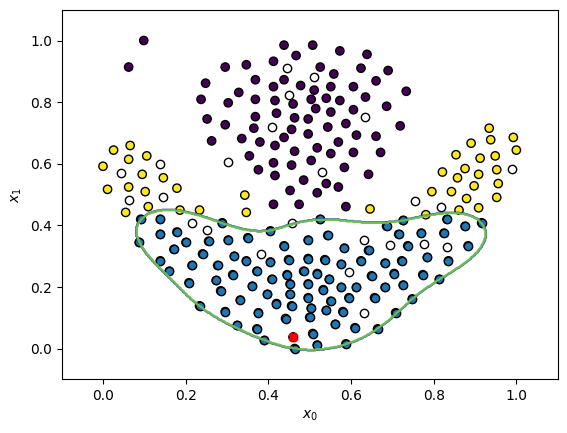

Explanation
.values =
array([-0.08,  0.44])

.base_values =
0.64

.data =
array([0.45985401, 0.03745318])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


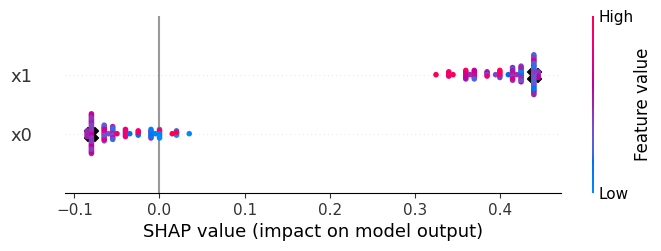

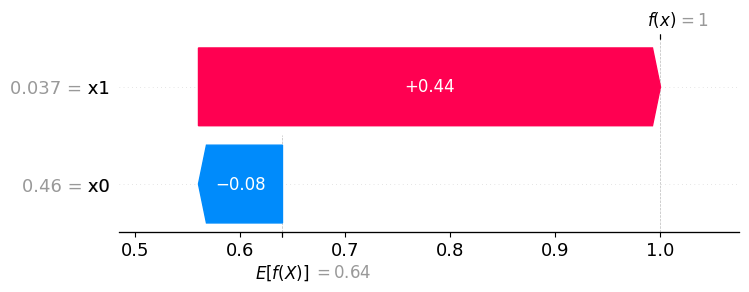

Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


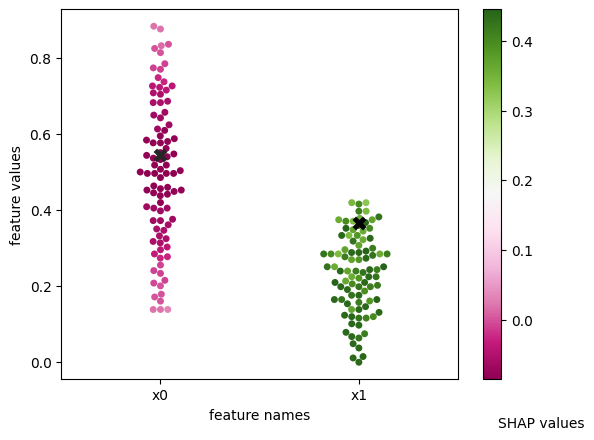

In [36]:
X_train, X_test, y_train, y_test, X, y, feature_names = load_dataset("flame")
model = train_model(X_train,y_train)

VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=0.2, gamma=20)
idx=50
explanation_VD(idx, X_test, X_train, VD, models_VD,explainer,feature_names)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


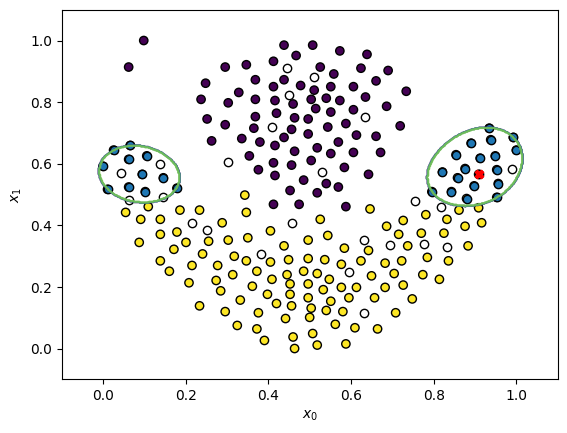

Explanation
.values =
array([ 0.39, -0.03])

.base_values =
0.64

.data =
array([0.90875912, 0.56554307])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


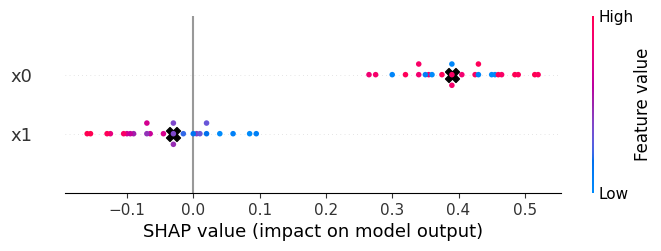

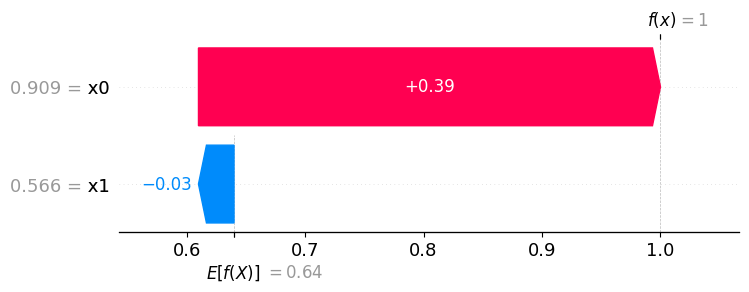

Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:k'` for same effect.
Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


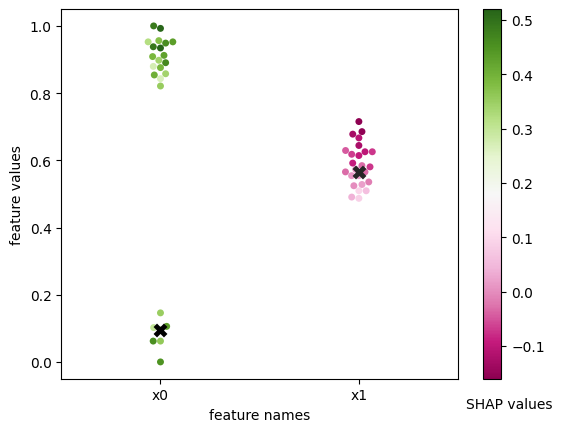

In [40]:
idx=70
explanation_VD(idx, X_test, X_train, VD, models_VD,explainer, feature_names)

Anchor fails when validity domain has multiple areas

In [59]:
explainer_a = anchor_tabular.AnchorTabularExplainer(
set(y),
feature_names,
X_train,
{})
print(X_train[idx])
exp = explainer_a.explain_instance(X_train[idx], model.predict, threshold=1)
exp.names()

[0.90875912 0.56554307]


['x1 <= 0.69', 'x0 > 0.64']

100%|██████████| 335/335 [00:00<00:00, 1731.19it/s]


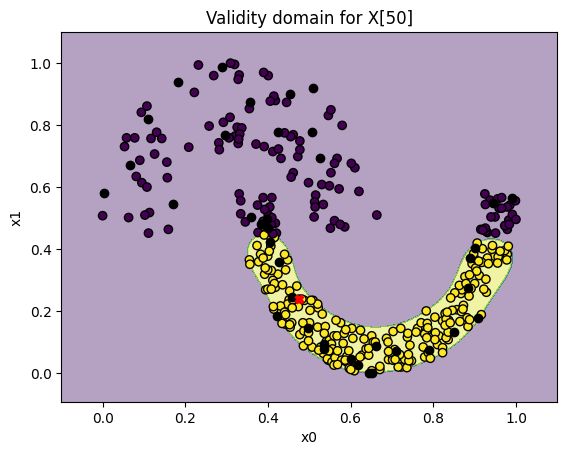

Explanation
.values =
array([ 0. , -0.3])

.base_values =
0.3

.data =
array([0.47472256, 0.23895582])


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


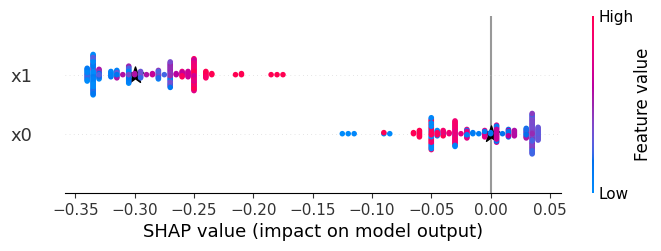

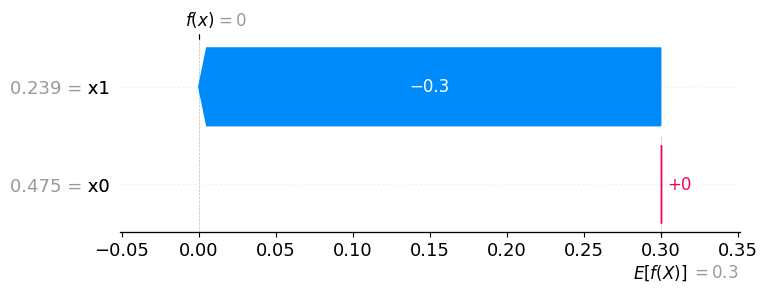

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


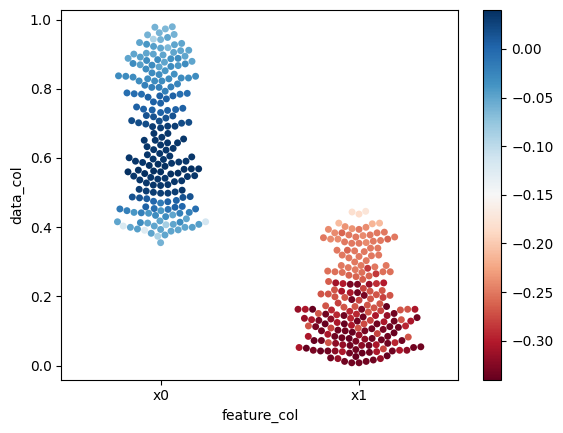

In [52]:
X_train, X_test, y_train, y_test, X, y, feature_names = load_dataset("jain")
model = train_model(X_train,y_train)

VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=0.2, gamma=30)
idx=50
explanation_VD(idx, X_test, X_train, VD, models_VD,explainer,feature_names)

# Sensitivity analysis

Curves

Distance threshold

In [233]:
dataset="flame"
X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train)
mean_precs = []
mean_cov = []
mean_dist_exp = []
mean_empty_VD = []
steps = []
for step in range(1,16):
    td=step/10
    steps.append(td)
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=td)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    mean_precs.append(np.mean(precs))
    mean_cov.append(np.mean(covs))
    mean_dist_exp.append(np.mean(dist_exp))
    mean_empty_VD.append(empty_VD/len(VD))

100%|██████████| 216/216 [00:00<00:00, 829.70it/s]


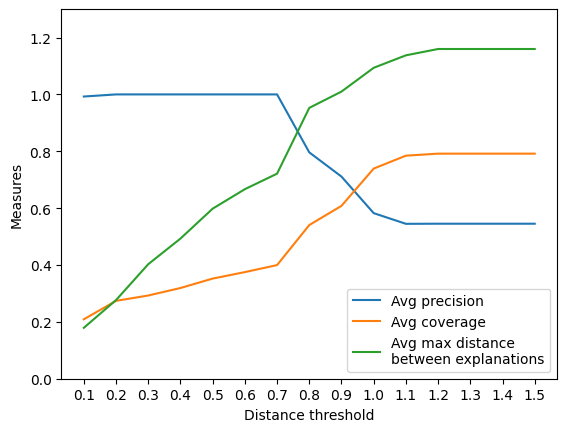

In [237]:
plt.figure()
# plt.title("Sensitivity analysis on flame dataset for distance threshold")
plt.plot(steps,mean_precs,label="Avg precision")
plt.plot(steps,mean_cov,label="Avg coverage")
plt.plot(steps,mean_dist_exp,label="Avg max distance\nbetween explanations")
# plt.plot(steps,mean_empty_VD, 'r+', label="Avg SVM failure")
plt.xticks(steps)
plt.ylim([0, 1.5])
plt.ylim([0, 1.3])
plt.legend()
plt.xlabel("Distance threshold")
plt.ylabel("Measures")
plt.savefig("toy_ex/sensitivity_curve_flame_dist.pdf")
plt.show()

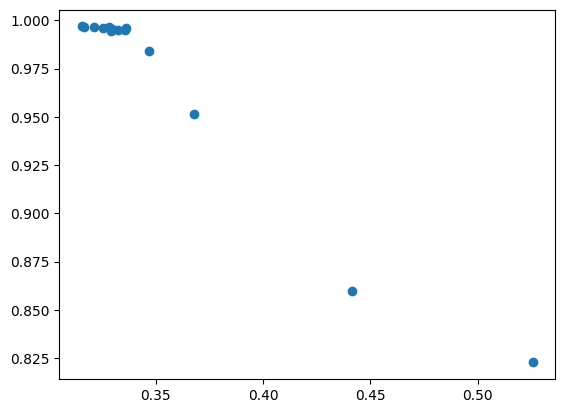

In [224]:
plt.figure()
# plt.title("Sensitivity analysis on flame dataset for distance threshold")
# plt.plot(steps,mean_precs,label="Avg precision")
# plt.plot(steps,mean_cov,label="Avg coverage")
# plt.plot(steps,mean_dist_exp,label="Avg max distance\nbetween explanations")
# plt.xticks(steps)
# plt.legend()
# plt.xlabel("Distance threshold")
# plt.ylabel("Measures")
plt.scatter(mean_cov,mean_precs)
plt.show()

In [323]:
print(mean_precs[6])
print(mean_cov[6])
print(steps[6])

1.0
0.41361882716049386
0.7


In [164]:
dataset="jain"
X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train)
mean_precs = []
mean_cov = []
mean_dist_exp = []
steps = []
for step in range(1,20):
    td=step/10
    steps.append(td)
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=td)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    mean_precs.append(np.mean(precs))
    mean_cov.append(np.mean(covs))
    mean_dist_exp.append(np.mean(dist_exp))

100%|██████████| 335/335 [00:00<00:00, 1056.27it/s]


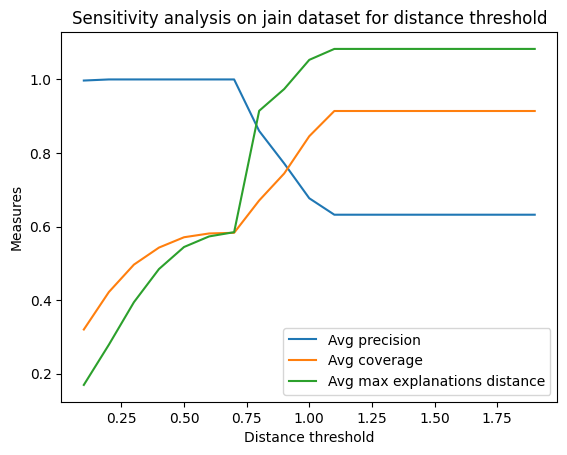

In [165]:
plt.figure()
plt.title("Sensitivity analysis on jain dataset for distance threshold")
plt.plot(steps,mean_precs,label="Avg precision")
plt.plot(steps,mean_cov,label="Avg coverage")
plt.plot(steps,mean_dist_exp,label="Avg max explanations distance")
plt.legend()
plt.xlabel("Distance threshold")
plt.ylabel("Measures")
plt.show()

In [11]:
dataset="adult_mini"
X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train)
mean_precs = []
mean_cov = []
mean_dist_exp = []
steps = []
for step in range(1,10):
    td=step/10
    steps.append(td)
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=td)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    mean_precs.append(np.mean(precs))
    mean_cov.append(np.mean(covs))
    mean_dist_exp.append(np.mean(dist_exp))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
100%|██████████| 270/270 [00:00<00:00, 2353.53it/s]
Permutation explainer: 301it [00:10,  1.52it/s]                         
100%|██████████| 270/270 [00:00<00:00, 333.46it/s]
Permutation explainer: 301it [00:10,  1.28s/it]                         
100%|██████████| 270/270 [00:00<00:00, 319.63it/s]


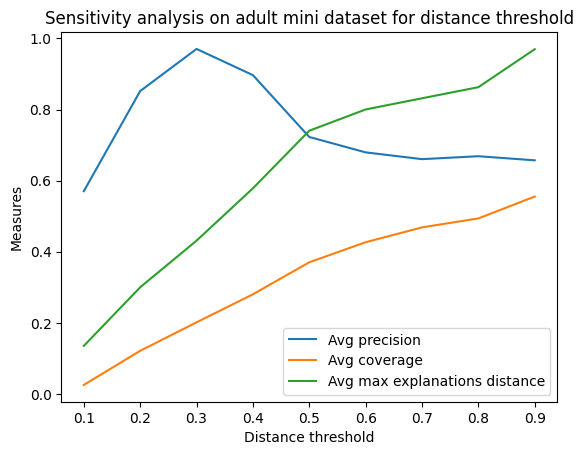

In [12]:
plt.figure()
plt.title("Sensitivity analysis on adult mini dataset for distance threshold")
plt.plot(steps,mean_precs,label="Avg precision")
plt.plot(steps,mean_cov,label="Avg coverage")
plt.plot(steps,mean_dist_exp,label="Avg max explanations distance")
plt.legend()
plt.xlabel("Distance threshold")
plt.ylabel("Measures")
plt.show()

In [9]:
dataset="iris"
X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train)
mean_precs = []
mean_cov = []
mean_dist_exp = []
steps = []
for step in range(1,10):
    td=step/10
    steps.append(td)
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=td)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    mean_precs.append(np.mean(precs))
    mean_cov.append(np.mean(covs))
    mean_dist_exp.append(np.mean(dist_exp))

100%|██████████| 135/135 [00:00<00:00, 1650.73it/s]


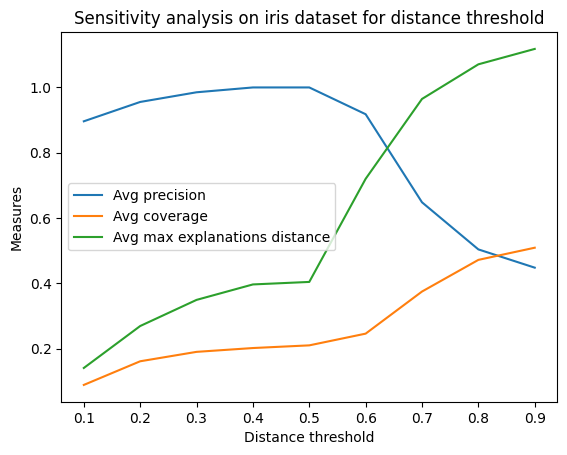

In [10]:
plt.figure()
plt.title("Sensitivity analysis on iris dataset for distance threshold")
plt.plot(steps,mean_precs,label="Avg precision")
plt.plot(steps,mean_cov,label="Avg coverage")
plt.plot(steps,mean_dist_exp,label="Avg max explanations distance")
plt.legend()
plt.xlabel("Distance threshold")
plt.ylabel("Measures")
plt.show()

In [48]:
dataset="loans_mini"
X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train)
mean_precs = []
mean_cov = []
mean_dist_exp = []
steps = []
for step in range(1,10):
    td=step/10
    steps.append(td)
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=td)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    mean_precs.append(np.mean(precs))
    mean_cov.append(np.mean(covs))
    mean_dist_exp.append(np.mean(dist_exp))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Permutation explainer: 271it [00:11,  2.85it/s]                         
100%|██████████| 270/270 [00:00<00:00, 451.20it/s]
Permutation explainer: 301it [00:13,  4.69it/s]                         
Permutation explainer: 271it [00:12,  3.47it/s]                         
Permutation explainer: 271it [00:12,  3.54it/s]                         
100%|██████████| 270/270 [00:00<00:00, 453.72it/s]
Permutation explainer: 301it [00:14,  6.12it/s]                         
Permutation explainer: 271it [00:11,  3.26it/s]                         
Permutation explainer: 271it [00:12,  3.85it/s]                         
100%|██████████| 270/270 [00:00<00:00, 452.19it/s]
Permutation explainer: 301it [00:13,  5.65it/s]                         
Permutation explainer: 271it [00:12,  3.51it/s]                         
Permutation explainer: 271it [00:11,  2.89it/s]          

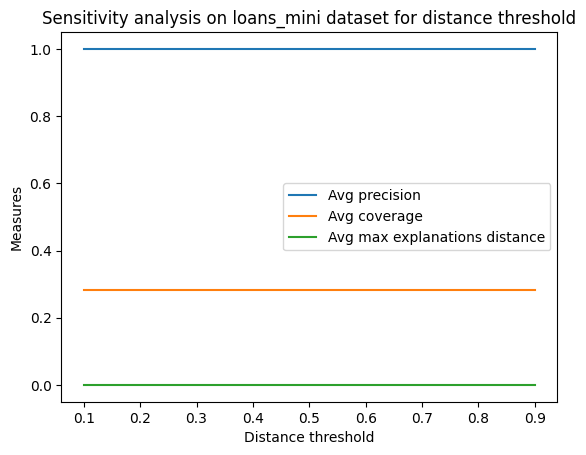

In [50]:
plt.figure()
plt.title("Sensitivity analysis on loans_mini dataset for distance threshold")
plt.plot(steps,mean_precs,label="Avg precision")
plt.plot(steps,mean_cov,label="Avg coverage")
plt.plot(steps,mean_dist_exp,label="Avg max explanations distance")
plt.legend()
plt.xlabel("Distance threshold")
plt.ylabel("Measures")
plt.show()

Gamma

In [337]:
dataset="jain"
X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train)
mean_precs = []
mean_cov = []
mean_dist_exp = []
steps = []
for step in range(1,25):
    gamma = step
    steps.append(gamma)
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=0.2, gamma=gamma)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    mean_precs.append(np.mean(precs))
    mean_cov.append(np.mean(covs))
    mean_dist_exp.append(np.mean(dist_exp))

100%|██████████| 335/335 [00:00<00:00, 1435.45it/s]


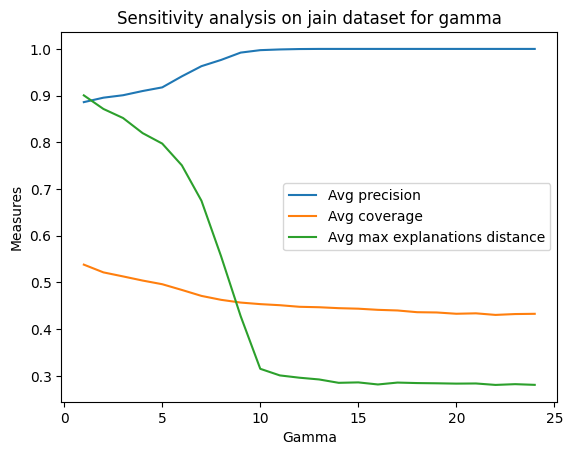

In [338]:
plt.figure()
plt.title("Sensitivity analysis on jain dataset for gamma")
plt.plot(steps,mean_precs,label="Avg precision")
plt.plot(steps,mean_cov,label="Avg coverage")
plt.plot(steps,mean_dist_exp,label="Avg max explanations distance")
plt.legend()
plt.xlabel("Gamma")
plt.ylabel("Measures")
plt.show()

In [238]:
dataset="flame"
X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train)
mean_precs = []
mean_cov = []
mean_dist_exp = []
steps = []
mean_precs_svm = []
mean_recalls_svm = []
mean_f1s_svm = []
for step in range(1,16):
    gamma = step
    steps.append(gamma)
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=0.2, gamma=gamma)
    precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
    dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
    precs_svm, recalls_svm, f1s_svm, supps = SVM_prec_recall(X, X_train, models_VD, model, feature_names, threshold_diff)
    mean_precs.append(np.mean(precs))
    mean_cov.append(np.mean(covs))
    mean_dist_exp.append(np.mean(dist_exp))

    mean_precs_svm.append(np.mean(precs_svm))
    mean_recalls_svm.append(np.mean(recalls_svm))
    mean_f1s_svm.append(np.mean(f1s_svm))

100%|██████████| 216/216 [00:00<00:00, 1628.40it/s]
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
100%|██████████| 216/216 [00:00<00:00, 2578.31it/s]


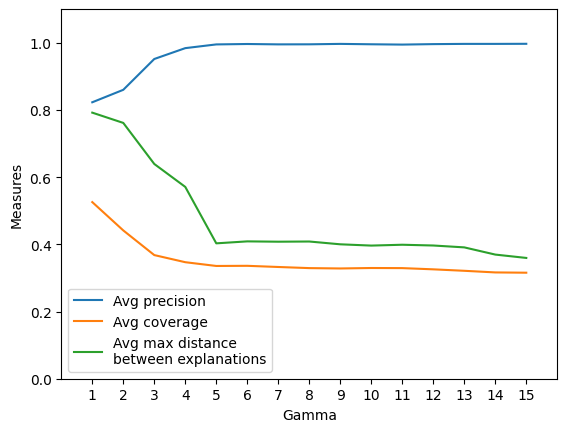

In [242]:
plt.figure()
# plt.title("Sensitivity analysis on flame dataset for gamma")
plt.plot(steps,mean_precs,label="Avg precision")
plt.plot(steps,mean_cov,label="Avg coverage")
plt.plot(steps,mean_dist_exp,label="Avg max distance\nbetween explanations")
plt.legend()
plt.xticks(steps)
plt.xlim([0, 16])
plt.ylim([0, 1.1])
plt.xlabel("Gamma")
plt.ylabel("Measures")
plt.savefig("toy_ex/sensitivity_curve_flame_gamma.pdf")
plt.show()

In [4]:
dataset="flame"
X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train)
steps = []
mean_precs_svm = []
mean_recalls_svm = []
mean_f1s_svm = []
for step in range(1,26):
    gamma = step*2
    steps.append(gamma)
    VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=0.2, gamma=gamma)
    precs_svm, recalls_svm, f1s_svm, supps = SVM_prec_recall(X, X_train, models_VD, model, feature_names, threshold_diff)
    mean_precs_svm.append(np.mean(precs_svm))
    mean_recalls_svm.append(np.mean(recalls_svm))
    mean_f1s_svm.append(np.mean(f1s_svm))

100%|██████████| 135/135 [00:00<00:00, 1856.23it/s]


NameError: name 'threshold_diff' is not defined

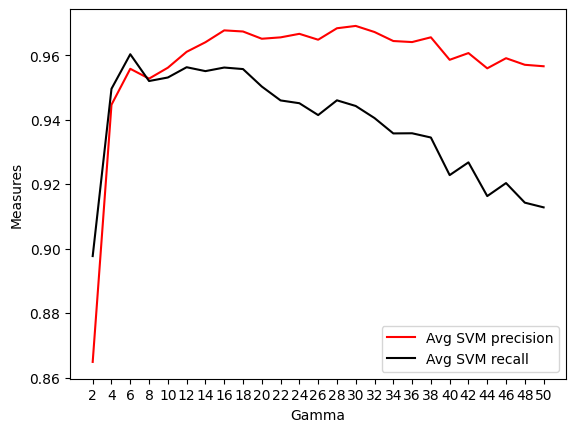

In [ ]:
plt.figure()
plt.plot(steps,mean_precs_svm,'r',label="Avg SVM precision")
plt.plot(steps,mean_recalls_svm,'k',label="Avg SVM recall")
# plt.plot(steps,mean_f1s_svm,label="Avg f1 score svm")
plt.xticks(steps)
# plt.ylim([0, 1])
plt.xlabel("Gamma")
plt.ylabel("Measures")
plt.legend()
plt.savefig("toy_ex/sensitivity_curve_flame_gamma_f1.pdf")
plt.show()

Heatmap

In [162]:
dataset="flame"
X_train, _, y_train, _, X, y, feature_names = load_dataset(dataset)
model = train_model(X_train,y_train)
mean_precs_df = []
mean_cov_df = []
mean_dist_exp_df = []
gammas_df = []
tds_df = []
for g in range(1,11):
    mean_precs = []
    mean_cov = []
    mean_dist_exp = []
    gammas = []
    tds = []
    for t in range(1,13):
        gamma = g
        gammas.append(gamma)
        td = t/10
        tds.append(td)

        VD, models_VD, explainer = validity_domains(X_train,feature_names,model,threshold_diff=td, gamma=gamma)
        precs,covs,covs_train = compute_precs_cov_VD(X, X_train, model, models_VD)
        dist_exp, dist_exp_train, dist_obs, dist_obs_train, empty_VD = diff_VD(X, X_train, models_VD, explainer)
        mean_precs.append(np.mean(precs))
        mean_cov.append(np.mean(covs))
        mean_dist_exp.append(np.mean(dist_exp))
    mean_precs_df.append(mean_precs)
    mean_cov_df.append(mean_cov)
    mean_dist_exp_df.append(mean_dist_exp)
    gammas_df.append(gammas)
    tds_df.append(tds)

100%|██████████| 216/216 [00:00<00:00, 1421.55it/s]


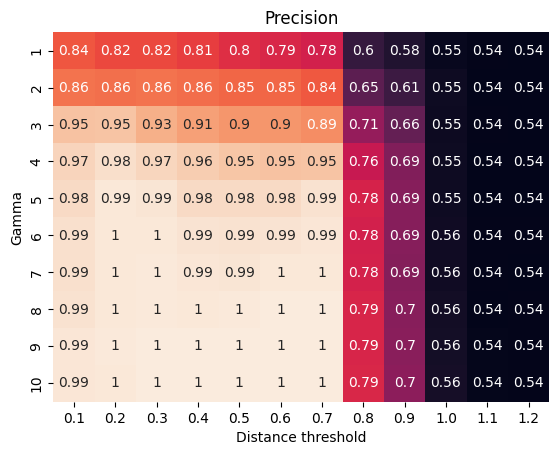

In [163]:
ax = sns.heatmap(pd.DataFrame(mean_precs_df),xticklabels=tds_df[0],yticklabels=np.asarray(gammas_df)[:,0], annot=True, cbar=False)
ax.set(xlabel="Distance threshold", ylabel="Gamma", title="Precision")
plt.savefig('toy_ex/heatmap_prec.pdf')

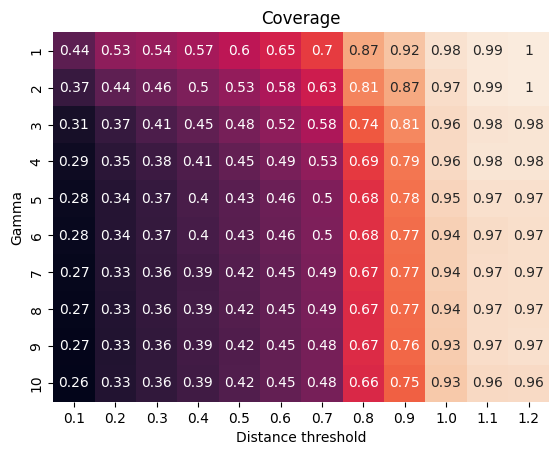

In [166]:
ax = sns.heatmap(pd.DataFrame(mean_cov_df),xticklabels=tds_df[0],yticklabels=np.asarray(gammas_df)[:,0], annot=True, cbar=False)
ax.set(xlabel="Distance threshold", ylabel="Gamma", title="Coverage")
plt.savefig('toy_ex/heatmap_cov.pdf')

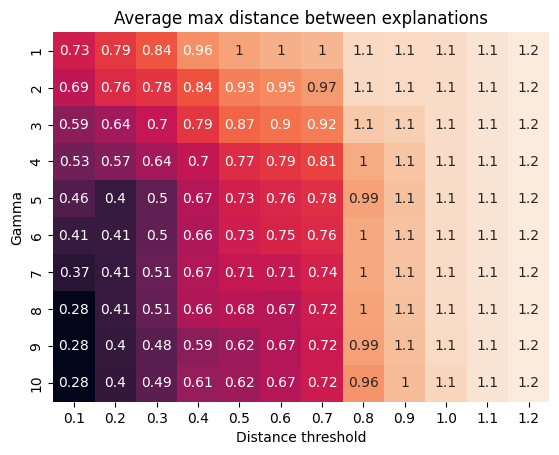

In [168]:
ax = sns.heatmap(pd.DataFrame(mean_dist_exp_df),xticklabels=tds_df[0],yticklabels=np.asarray(gammas_df)[:,0], annot=True, cbar=False)
ax.set(xlabel="Distance threshold", ylabel="Gamma", title="Average max distance between explanations")
plt.savefig('toy_ex/heatmap_max_dist.pdf')